##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:
df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [6]:
df.values.shape

(275, 7)

## Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [7]:
#to print the first 10 rows in the dataframe
df.head(10)

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0
5,-115.132162,36.100841,5,1,3,4,1
6,-115.176012,36.194067,1,1,4,5,2
7,-115.194061,36.135213,3,1,4,3,1
8,-115.069716,36.191304,0,1,5,6,0
9,-115.309341,36.074367,6,1,6,1,0


*Latitude and Longitude: These columns represent the geographical coordinates (location) of the incident.
*Hour of the day: This column indicates the hour of the day when the incident occurred.
*Day of the week: This column represents the day of the week when the incident occurred.
*Area-of-command code: This column is related to the police designation of the bureau of the operation.
*Classification code for the crime committed: This column specifies the type or classification of the crime committed.
*Number of persons involved in the accident: This is the target variable that we want to predict which represents the count of individuals involved in the incident

Inputs:1)Latitude and Longitude
       2)Hour of the day
       3)Day of the week
       4)Area-of-command code
       5)Classification code for the crime committed
Output:Number of persons involved in the crime

In [8]:
df.describe()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,-115.159326,36.143360,3.978182,0.909091,2.981818,11.236364,0.712727
std,0.101294,0.118418,3.045799,0.334878,1.924590,7.039937,0.978427
min,-116.000000,35.068419,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-115.209198,36.114704,1.000000,1.000000,1.000000,5.000000,0.000000
50%,-115.149945,36.152415,3.000000,1.000000,3.000000,11.000000,0.000000
75%,-115.105200,36.183854,6.000000,1.000000,5.000000,18.000000,1.000000
max,-114.625571,37.000000,11.000000,2.000000,6.000000,23.000000,6.000000


Range of Values:

X Coordinate:
Maximum: -114.625570
Minimum: -116.000000

Y Coordinate:
Maximum: 37.000000
Minimum: -35.068419

Area Command:
Maximum: 11.000000
Minimum: 0.000000
Note: This is a categorical variable and may require one-hot encoding.

NIBRS Offense Code:
Maximum: 2.000000
Minimum: 0.000000

Day of Week:
Maximum: 6.000000
Minimum: 0.000000

Time:
Maximum: 23.000000
Minimum: 0.000000

Victim Count:
Maximum: 6.000000
Minimum: 0.000000

Data Characteristics:
Scaling Requirement: No scaling is required due to the narrow range of values for each column.

Categorical Data: The "Area Command" column is categorical and may need encoding techniques such as one-hot encoding and maybe we can do Normalization for the better control over values.

Missing Values: There are no missing values in the dataset.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [9]:
# Spliting the dataset into training and testing sets, e.g., 80% for training, 20% for testing
train_ratio = 0.8
train_size = int(train_ratio * len(df))
test_size = len(df) - train_size
train_data, test_data = df[:train_size], df[train_size:]

# Defining a custom PyTorch Dataset class to handle your data
class CustomisedDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        x = sample[:-1] 
        y = sample[-1]
        return x, y

# Defining batch size
size_of_batch = 64

# Creating DataLoader objects for training and testing
train_dataset = CustomisedDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=size_of_batch, shuffle=True)

test_dataset = CustomisedDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=size_of_batch, shuffle=False)

# Verify the shape of data by iterating over the DataLoader
for batch in train_loader:
    inputs, targets = batch
    print("Shape of the Input batch:", inputs.shape)
    print("Shape of the Target batch:", targets.shape)
    break


Shape of the Input batch: torch.Size([64, 6])
Shape of the Target batch: torch.Size([64])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

1) **Loss Function:** In regression tasks, Mean Squared Error (MSE) is frequently employed as the loss function since it calculates the average squared difference between predicted and actual values. Hence, for this particular task, MSE loss is suitable.

2) **Output Size:** Considering we are predicting a singular real number (The number of crime victims), the output size of our model should be set to 1.

3) **Architecture Selection:** Determining the number of layers and hidden units in each layer is a crucial hyperparameter that requires experimentation. A recommended starting point could be using 2 or 3 hidden layers, each containing around 64 hidden units. However, these parameters are flexible and can be adjusted based on the model's performance.

4) **Optimizer and Learning Rate:** While Stochastic Gradient Descent (SGD) is a common optimizer for neural networks, Adam optimizer might be a better choice in this context. Adam is preferred due to its ability to handle 'Nan' losses, a challenge often encountered when using SGD. Additionally, starting with a moderate learning rate, such as 0.01, is advisable. This learning rate can be adjusted dynamically during training to optimize the model's accuracy.


In [10]:
import torch.nn as nn
import torch.optim as optim

#Building neural network architecture
class RegressionCrimePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionCrimePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Defining the model, loss function, and optimizer
input_size = len(train_dataset[0][0])
output_size = 1 
hidden_size = 64
regressionModel = RegressionCrimePredictor(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(regressionModel.parameters(), lr=0.01)

# Training loop
num_of_epochs = 30
for epoch in range(num_of_epochs):
    regressionModel.train()
    total_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = regressionModel(inputs.float())
        loss = criterion(outputs, targets.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_of_epochs}] - Loss: {average_loss:.4f}")

# Testing the model
regressionModel.eval()
total_mse = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = regressionModel(inputs.float())
        mse = criterion(outputs, targets.float().view(-1, 1))
        total_mse += mse.item()
    average_mse = total_mse / len(test_loader)
    print(f"Test MSE: {average_mse:.4f}")

Epoch [1/30] - Loss: 22.6423
Epoch [2/30] - Loss: 6.0480
Epoch [3/30] - Loss: 1.6384
Epoch [4/30] - Loss: 1.8974
Epoch [5/30] - Loss: 0.9699
Epoch [6/30] - Loss: 1.2373
Epoch [7/30] - Loss: 1.1016
Epoch [8/30] - Loss: 0.9144
Epoch [9/30] - Loss: 0.8782
Epoch [10/30] - Loss: 0.9174
Epoch [11/30] - Loss: 0.7882
Epoch [12/30] - Loss: 0.8652
Epoch [13/30] - Loss: 0.8750
Epoch [14/30] - Loss: 0.7442
Epoch [15/30] - Loss: 0.9376
Epoch [16/30] - Loss: 0.8310
Epoch [17/30] - Loss: 0.7813
Epoch [18/30] - Loss: 0.7998
Epoch [19/30] - Loss: 0.7741
Epoch [20/30] - Loss: 0.8470
Epoch [21/30] - Loss: 0.7542
Epoch [22/30] - Loss: 0.7963
Epoch [23/30] - Loss: 0.7685
Epoch [24/30] - Loss: 0.8731
Epoch [25/30] - Loss: 0.8015
Epoch [26/30] - Loss: 0.8029
Epoch [27/30] - Loss: 0.7966
Epoch [28/30] - Loss: 0.7803
Epoch [29/30] - Loss: 0.7387
Epoch [30/30] - Loss: 0.9414
Test MSE: 1.5187


*Switching Optimizers:* The problem of encountering 'Nan' losses was resolved by switching from SGD to Adam as the optimizer.
*Learning Rate Adjustment:* A minor increase in the average MSE was observed when the learning rate was reduced from 0.01 to 0.001.
*Epoch Variation:* Gradual adjustments in the number of epochs resulted in a decline in loss and an improvement in accuracy. However, beyond a certain point, like 30 epochs in my case, there was limited enhancement in accuracy despite further changes.
*Hidden Unit Optimization:* Through experimentation with various hidden unit values while keeping other parameters constant, it was determined that having 64 units yielded the lowest loss and improved accuracy.

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

**Number of Output Classes:** The predicted output size should correspond to the number of distinct classes present in the CrimeStats Dataset, determined by examining the unique class labels in the "number of crime victims" column.

**Architecture Consideration:** In contrast to the regression scenario, the architecture needs to be adapted for classification. Specifically, an output layer with softmax activation should be utilized to generate class probabilities. The architecture, including the number of layers and hidden units, can be adjusted based on the model's accuracy after each testing iteration.

**Choice of Loss Function:** For classification tasks, it's essential to employ a categorical cross-entropy loss function. Therefore, we will use `nn.CrossEntropyLoss` for this purpose.

In [11]:
# Define your neural network architecture
class ClassificationCrimeClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationCrimeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Determine the number of classes based on your data
num_of_classes = len(df['VictimCount'].unique())

# Define the model, loss function, and optimizer
input_size = len(train_dataset[0][0])  # Input features
hidden_size = 64  # Experiment with different values
classifierModel = ClassificationCrimeClassifier(input_size, hidden_size, num_of_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifierModel.parameters(), lr=0.01)

# Training loop
num_epochs = 20 # Experiment with different numbers of epochs
for epoch in range(num_epochs):
    classifierModel.train()
    total_loss = 0.0
    correct_predictions = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = classifierModel(inputs.float())
        loss = criterion(outputs, targets.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()

    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / len(train_data)  # Training accuracy

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f} - Training Accuracy: {accuracy:.4f}")

    # Testing the model
    classifierModel.eval()
    correct_predictions = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = classifierModel(inputs.float())
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()

        test_accuracy = correct_predictions / len(test_data)
        print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch [1/20] - Loss: 14.5794 - Training Accuracy: 0.2773
Test Accuracy: 0.0182
Epoch [2/20] - Loss: 1.5361 - Training Accuracy: 0.2682
Test Accuracy: 0.4909
Epoch [3/20] - Loss: 1.1870 - Training Accuracy: 0.4500
Test Accuracy: 0.4909
Epoch [4/20] - Loss: 1.1214 - Training Accuracy: 0.5227
Test Accuracy: 0.4909
Epoch [5/20] - Loss: 1.1378 - Training Accuracy: 0.4864
Test Accuracy: 0.4909
Epoch [6/20] - Loss: 1.1238 - Training Accuracy: 0.5227
Test Accuracy: 0.3636
Epoch [7/20] - Loss: 1.0863 - Training Accuracy: 0.4500
Test Accuracy: 0.4000
Epoch [8/20] - Loss: 1.0609 - Training Accuracy: 0.5273
Test Accuracy: 0.4909
Epoch [9/20] - Loss: 1.0616 - Training Accuracy: 0.4864
Test Accuracy: 0.4909
Epoch [10/20] - Loss: 1.1043 - Training Accuracy: 0.4455
Test Accuracy: 0.4909
Epoch [11/20] - Loss: 1.0444 - Training Accuracy: 0.5227
Test Accuracy: 0.4909
Epoch [12/20] - Loss: 1.0735 - Training Accuracy: 0.4864
Test Accuracy: 0.4909
Epoch [13/20] - Loss: 1.0380 - Training Accuracy: 0.5227
Tes

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

In the regression scenario, our objective was to predict a continuous real number, necessitating the use of Mean Squared Error (MSE) as the loss function. MSE measured the variation between predicted and observed values, with the aim of minimizing prediction errors for crime victim quantities. The accuracy of the regression model was quantitatively assessed based on its ability to precisely predict numerical values.

Conversely, in the classification model, we employed Cross-Entropy loss to categorize crime victims into discrete classes. The determination of the number of classes was rooted in the unique labels present in the "VictimCount" column. Classification models are geared towards accurately classifying data points into categories. Evaluation metrics such as accuracy gauged the model's performance by measuring the proportion of correctly classified instances.

The choice between these models hinges on the specific problem and dataset at hand. If the task demands precise prediction of victim numbers, the regression model excels. However, for broader categorization of crimes (e.g., classifying victim counts as "low," "medium," or "high"), the classification model proves more suitable.

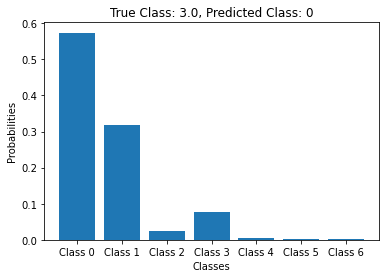

In [12]:
import matplotlib.pyplot as plt

# Assuming 'test_data' contains the test dataset
example_idx = 0  # Change this index to select a specific example
example_inputs, true_class = test_dataset[example_idx]

# Convert example_inputs to a PyTorch tensor
example_inputs = torch.tensor(example_inputs, dtype=torch.float64)

# Convert the model parameters to Double data type
model = classifierModel.double()

model.eval()
with torch.no_grad():
    outputs = model(example_inputs)
    probabilities = torch.softmax(outputs, dim=0)
    predicted_class = torch.argmax(outputs).item()

# Visualize the class probabilities
classes = [f"Class {i}" for i in range(num_of_classes)]
plt.bar(classes, probabilities)
plt.xlabel("Classes")
plt.ylabel("Probabilities")
plt.title(f"True Class: {true_class}, Predicted Class: {predicted_class}")
plt.show()

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


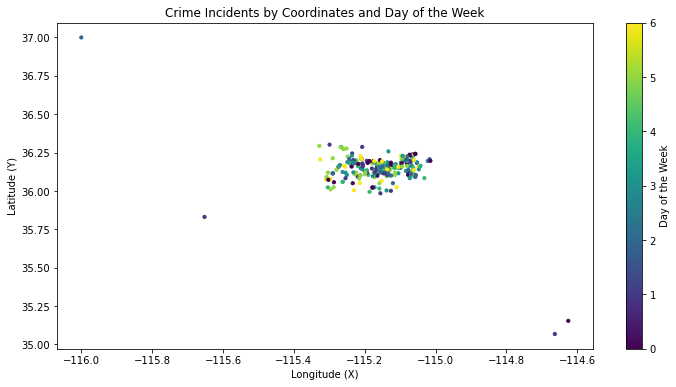

In [13]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', s=10)
plt.colorbar(label='Day of the Week')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Coordinates and Day of the Week')
plt.show()

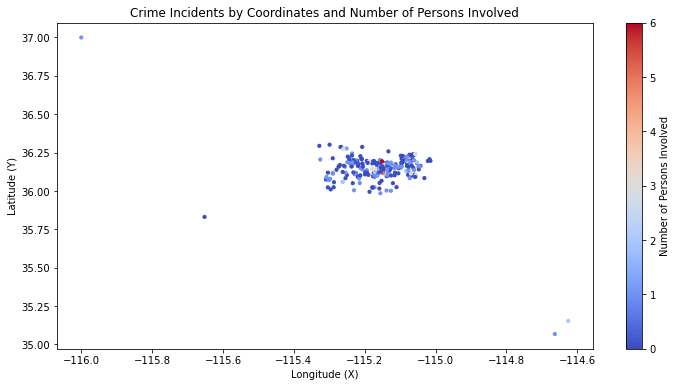

In [14]:
# Scatter plot based on coordinates with number of persons involved as color
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='coolwarm', s=10)
plt.colorbar(label='Number of Persons Involved')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Coordinates and Number of Persons Involved')
plt.show()

In [15]:
import numpy as np

# Count the number of crimes reported by day of the week
crime_count_by_day = np.bincount(df['DayOfWeek'])

# Create a dictionary to map day indices to day names
day_mapping = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Create a list of day names sorted by crime count
sorted_days = [(day_mapping[i]+" "+ str(crime_count_by_day[i])) for i in np.argsort(crime_count_by_day)[::-1]]

# Display the most frequent days
print("Most frequent days for reported crimes:")
for day in sorted_days:
    print(day)

Most frequent days for reported crimes:
Friday 51
Thursday 44
Saturday 43
Monday 40
Tuesday 37
Wednesday 32
Sunday 28
